In [1]:
import torch
from transformers import AutoConfig, AutoImageProcessor, AutoModelForVision2Seq, AutoProcessor
import time
import numpy as np
import cv2
import textwrap
from PIL import Image, ImageDraw, ImageFont
import enum
import json
import os 


/home/zhekai/miniforge3/envs/openvla/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-21 17:07:51.554423: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-21 17:07:51.583165: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-21 17:07:51.583185: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-21 17:

In [2]:
#Define some utils.

def split_reasoning(text, tags):
    new_parts = {None: text}

    for tag in tags:
        parts = new_parts
        new_parts = dict()

        for k, v in parts.items():
            if tag in v:
                s = v.split(tag)
                new_parts[k] = s[0]
                new_parts[tag] = s[1]
                # print(tag, s)
            else:
                new_parts[k] = v

    return new_parts

class CotTag(enum.Enum):
    TASK = "TASK:"
    PLAN = "PLAN:"
    VISIBLE_OBJECTS = "VISIBLE OBJECTS:"
    SUBTASK_REASONING = "SUBTASK REASONING:"
    SUBTASK = "SUBTASK:"
    MOVE_REASONING = "MOVE REASONING:"
    MOVE = "MOVE:"
    GRIPPER_POSITION = "GRIPPER POSITION:"
    ACTION = "ACTION:"


def get_cot_tags_list():
    return [
        CotTag.TASK.value,
        CotTag.PLAN.value,
        CotTag.VISIBLE_OBJECTS.value,
        CotTag.SUBTASK_REASONING.value,
        CotTag.SUBTASK.value,
        CotTag.MOVE_REASONING.value,
        CotTag.MOVE.value,
        CotTag.GRIPPER_POSITION.value,
        CotTag.ACTION.value,
    ]

def name_to_random_color(name):
    return [(hash(name) // (256**i)) % 256 for i in range(3)]


def draw_gripper(img, pos_list, img_size=(640, 480)):
    for i, pos in enumerate(reversed(pos_list)):
        pos = resize_pos(pos, img_size)
        scale = 255 - int(255 * i / len(pos_list))
        cv2.circle(img, pos, 6, (0, 0, 0), -1)
        cv2.circle(img, pos, 5, (scale, scale, 255), -1)

def get_metadata(reasoning):
    metadata = {"gripper": [[0, 0]], "bboxes": dict()}

    if f" {CotTag.GRIPPER_POSITION.value}" in reasoning:
        gripper_pos = reasoning[f" {CotTag.GRIPPER_POSITION.value}"]
        gripper_pos = gripper_pos.split("[")[-1]
        gripper_pos = gripper_pos.split("]")[0]
        gripper_pos = [int(x) for x in gripper_pos.split(",")]
        gripper_pos = [(gripper_pos[2 * i], gripper_pos[2 * i + 1]) for i in range(len(gripper_pos) // 2)]
        metadata["gripper"] = gripper_pos

    if f" {CotTag.VISIBLE_OBJECTS.value}" in reasoning:
        for sample in reasoning[f" {CotTag.VISIBLE_OBJECTS.value}"].split("]"):
            obj = sample.split("[")[0]
            if obj == "":
                continue
            coords = [int(n) for n in sample.split("[")[-1].split(",")]
            metadata["bboxes"][obj] = coords

    return metadata

def resize_pos(pos, img_size):
    return [(x * size) // 256 for x, size in zip(pos, img_size)]

def draw_bboxes(img, bboxes, img_size=(640, 480)):
    for name, bbox in bboxes.items():
        show_name = name
        # show_name = f'{name}; {str(bbox)}'

        cv2.rectangle(
            img,
            resize_pos((bbox[0], bbox[1]), img_size),
            resize_pos((bbox[2], bbox[3]), img_size),
            name_to_random_color(name),
            1,
        )
        cv2.putText(
            img,
            show_name,
            resize_pos((bbox[0], bbox[1] + 6), img_size),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 255, 255),
            1,
            cv2.LINE_AA,
        )

In [3]:
device = "cuda:0"
# Load Processor & VLA
path_to_converted_ckpt = "Embodied-CoT/ecot-openvla-7b-bridge"
# path_to_converted_ckpt = "Embodied-CoT/ecot-openvla-7b-oxe"
# path_to_converted_ckpt = "../openvla/logs/ecot-openvla-7b-oxe+libero_spatial_no_noops+b16+lr-0.0005+lora-r32+dropout-0.0--image_aug"
processor = AutoProcessor.from_pretrained(path_to_converted_ckpt, trust_remote_code=True)
vla = AutoModelForVision2Seq.from_pretrained(
    path_to_converted_ckpt,
    # attn_implementation="flash_attention_2",  # [Optional] Requires `flash_attn`
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    trust_remote_code=True,
).to(device)

Expected `transformers==4.40.1` and `tokenizers==0.19.1` but got `transformers==4.46.1` and `tokenizers==0.20.1`; there might be inference-time regressions due to dependency changes. If in doubt, pleaseuse the above versions.
Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00,  3.98it/s]


In [4]:
SYSTEM_PROMPT = (
    "A chat between a curious user and an artificial intelligence assistant. "
    "The assistant gives helpful, detailed, and polite answers to the user's questions."
)
t = CotTag.TASK.value
def get_openvla_prompt(instruction: str, task) -> str:
    return f"{SYSTEM_PROMPT} USER: What action should the robot take to {instruction.lower()}? ASSISTANT: {task}"

INSTRUCTION = "place the watermelon on the towel"
prompt = get_openvla_prompt(INSTRUCTION, t)
image = Image.open("./test_obs.png")
print(prompt.replace(". ", ".\n"))
# print("Image size:", image.size)

A chat between a curious user and an artificial intelligence assistant.
The assistant gives helpful, detailed, and polite answers to the user's questions.
USER: What action should the robot take to place the watermelon on the towel? ASSISTANT: TASK:


In [5]:
inputs = processor(prompt, image).to(device, dtype=torch.bfloat16)
dataset_statistics_path = os.path.join(path_to_converted_ckpt, "dataset_statistics.json")
if os.path.isfile(dataset_statistics_path):
    with open(dataset_statistics_path, "r") as f:
        norm_stats = json.load(f)
    vla.norm_stats = norm_stats
# action, generated_ids = vla.predict_action(**inputs, unnorm_key='libero_spatial_no_noops', do_sample=False, max_new_tokens=1024)
# generated_text = processor.batch_decode(generated_ids)[0]
# print(generated_text)

different prompt tests 

In [7]:
prompts = []
for t in CotTag:
    prompt_b = f"{SYSTEM_PROMPT} USER: What action should the robot take to {INSTRUCTION.lower()}? ASSISTANT: {t.value}"
    prompts.append(prompt_b)
# left padding
processor.tokenizer.padding_side = 'left'
inputs = processor(prompt, image, padding=True).to(device, dtype=torch.bfloat16)

In [9]:
# use cuda timmer ·
# start = torch.cuda.Event(enable_timing=True)
# end = torch.cuda.Event(enable_timing=True)
# start.record()
action, generated_ids = vla.predict_action(**inputs, unnorm_key='bridge_orig', do_sample=False, max_new_tokens=1024)
# end.record()
# torch.cuda.synchronize()
# print(start.elapsed_time(end))
generated_text = processor.batch_decode(generated_ids)
print(generated_text)

["<s> A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: What action should the robot take to place the watermelon on the towel? ASSISTANT: TASK: Place the watermelon on the towel. PLAN: Move to the watermelon, grasp it, move to the towel, release the watermelon. SUBTASK REASONING: The watermelon is grasped and needs to be moved to the towel. SUBTASK: Move to the towel. MOVE REASONING: The towel is to the right of the watermelon, so the robot needs to move right to reach it. MOVE: Move right. GRIPPER POSITION: [113, 91] VISIBLE OBJECTS: a pink watermelon [65, 84, 135, 110], a pink watermelon [66, 83, 135, 109], the scene [4, 0, 243, 249], a yellow spoon the spoon [14, 120, 97, 150], the towel [156, 99, 230, 158], a red mushroom and the mushroom is on the table near the [107, 150, 153, 203] ACTION: 話奇彦装操ഷŸ</s>"]


In [10]:
for i in range(len(prompts)):
    # print(f"Prompt: {prompts[i]}")
    print(f"Generated: {generated_text[i]}")
    print("")

Generated: <s> A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: What action should the robot take to place the watermelon on the towel? ASSISTANT: TASK: Place the watermelon on the towel. PLAN: Move to the watermelon, grasp it, move to the towel, release the watermelon. SUBTASK REASONING: The watermelon is grasped and needs to be moved to the towel. SUBTASK: Move to the towel. MOVE REASONING: The towel is to the right of the watermelon, so the robot needs to move right to reach it. MOVE: Move right. GRIPPER POSITION: [113, 91] VISIBLE OBJECTS: a pink watermelon [65, 84, 135, 110], a pink watermelon [66, 83, 135, 109], the scene [4, 0, 243, 249], a yellow spoon the spoon [14, 120, 97, 150], the towel [156, 99, 230, 158], a red mushroom and the mushroom is on the table near the [107, 150, 153, 203] ACTION: 話奇彦装操ഷŸ</s>



IndexError: list index out of range

In [9]:
# for t in CotTag:
#     prompt_b = f"{SYSTEM_PROMPT} USER: What action should the robot take to {INSTRUCTION.lower()}? ASSISTANT: {t.value}"
#     inputs = processor(prompt_b, image).to(device, dtype=torch.bfloat16)
#     action, generated_ids = vla.predict_action(**inputs, unnorm_key='libero_spatial_no_noops', do_sample=False, max_new_tokens=1024)
#     generated_text = processor.batch_decode(generated_ids)[0]
#     print(generated_text)
#     print("")

In [10]:
from transformers.image_processing_base import BatchFeature

# List to collect BatchFeature instances
processed_data = []
pad_len =70
for t in CotTag:
    prompt_b = f"{SYSTEM_PROMPT} USER: What action should the robot take to {INSTRUCTION.lower()}? ASSISTANT: {t.value}"
    processed = processor(prompt_b, image).to(device, dtype=torch.bfloat16)
    # pad input_ids and attention_mask to the same length [1, 70]
    processed['input_ids'] = torch.cat([processed['input_ids'], torch.zeros((1, pad_len - processed['input_ids'].shape[1]), dtype=torch.int64).to(device)], dim=1)
    processed['attention_mask'] = torch.cat([processed['attention_mask'], torch.ones((1, pad_len - processed['attention_mask'].shape[1]), dtype=torch.int64).to(device)], dim=1)

    processed_data.append(processed)
    # for keys in processed.keys():
    #     print(keys, processed[keys].shape)

# Combine the BatchFeature instances into a single batch
batched_data = BatchFeature({
    key: torch.cat([item[key] for item in processed_data], dim=0)
    for key in processed_data[0].keys()
}, tensor_type="pt")

In [ ]:
action, generated_ids = vla.predict_action(**batched_data, unnorm_key='libero_spatial_no_noops', do_sample=False, max_new_tokens=1024)
print(torch.cuda.memory_summary(device))


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 10        |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  14415 MiB |  21041 MiB |   1988 GiB |   1973 GiB |
|       from large pool |  14406 MiB |  21031 MiB |   1909 GiB |   1895 GiB |
|       from small pool |      8 MiB |     10 MiB |     78 GiB |     78 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  14415 MiB |  21041 MiB |   1988 GiB |   1973 GiB |
|       from large pool |  14406 MiB |  21031 MiB |   1909 GiB |

In [ ]:
# for t in CotTag:
#     prompt_b = f"{SYSTEM_PROMPT} USER: What action should the robot take to {INSTRUCTION.lower()}? ASSISTANT: {t.value}"
#     input = processor(prompt_b, image).to(device, dtype=torch.bfloat16)
#     #make into batch
#     inputs = input

In [13]:
# from torch.profiler import profile, record_function, ProfilerActivity

# # === BFLOAT16 MODE ===

# # inputs["input_ids"] = inputs["input_ids"][:, 1:]

# # Run OpenVLA Inference
# start_time = time.time()
# torch.manual_seed(0)

# def trace_handler(prof):
#     # print(prof.key_averages().table(
#     #     sort_by="self_cuda_time_total", row_limit=-1))
#     prof.export_chrome_trace("tmp/test_trace_" + str(prof.step_num) + ".json")

# # with torch.profiler.profile(
# #     activities=[
# #         torch.profiler.ProfilerActivity.CPU,
# #         torch.profiler.ProfilerActivity.CUDA,
# #     ],
# #     schedule=torch.profiler.schedule(
# #         wait=1,
# #         warmup=1,
# #         active=1),
# #     on_trace_ready=trace_handler,
# #     with_stack=True,
# #     profile_memory=True,
# #     with_flops = True
# #     ) as p:
# #         for iter in range(3):
# #             # torch.square(torch.randn(10000, 10000).cuda())
# #             action, generated_ids = vla.predict_action(**inputs, unnorm_key="bridge_orig", do_sample=False, max_new_tokens=1024)
# #             p.step()
# #             # send a signal to the profiler that the next iteration has started
            
# # generated_text = processor.batch_decode(generated_ids)[0]
# # print(f"Time: {time.time() - start_time:.4f} || Action: {action}")


In [14]:
# #torch cuda event
# start = torch.cuda.Event(enable_timing=True)
# end = torch.cuda.Event(enable_timing=True)
# times = []
# for i in range(10):
#     start.record()
#     action, generated_ids = vla.predict_action(**inputs, unnorm_key="fractal20220817_data", do_sample=False, max_new_tokens=1024)
#     end.record()
#     torch.cuda.synchronize()
#     times.append(start.elapsed_time(end))
# print("Average inference time: ", sum(times)/len(times))
# print("Std: ", torch.tensor(times).std().item())

In [15]:
#profile memroy with torch
print(torch.cuda.memory_summary(device))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 10        |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  14415 MiB |  21041 MiB |   1988 GiB |   1973 GiB |
|       from large pool |  14406 MiB |  21031 MiB |   1909 GiB |   1895 GiB |
|       from small pool |      8 MiB |     10 MiB |     78 GiB |     78 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  14415 MiB |  21041 MiB |   1988 GiB |   1973 GiB |
|       from large pool |  14406 MiB |  21031 MiB |   1909 GiB |

In [11]:
tags = [f" {tag}" for tag in get_cot_tags_list()]
reasoning = split_reasoning(generated_text, tags)
text = [tag + reasoning[tag] for tag in [' TASK:',' PLAN:',' SUBTASK REASONING:',' SUBTASK:',
                                        ' MOVE REASONING:',' MOVE:', ' VISIBLE OBJECTS:', ' GRIPPER POSITION:'] if tag in reasoning]
metadata = get_metadata(reasoning)
bboxes = {}
for k, v in metadata["bboxes"].items():
    if k[0] == ",":
        k = k[1:]
    bboxes[k.lstrip().rstrip()] = v

caption = ""
for t in text:
    wrapper = textwrap.TextWrapper(width=80, replace_whitespace=False) 
    word_list = wrapper.wrap(text=t) 
    caption_new = ''
    for ii in word_list[:-1]:
        caption_new = caption_new + ii + '\n      '
    caption_new += word_list[-1]

    caption += caption_new.lstrip() + "\n\n"

base = Image.fromarray(np.ones((480, 640, 3), dtype=np.uint8) * 255)
draw = ImageDraw.Draw(base)
font = ImageFont.load_default(size=14) # big text
color = (0,0,0) # RGB
draw.text((30, 30), caption, color, font=font)

img_arr = np.array(image)
draw_gripper(img_arr, metadata["gripper"])
draw_bboxes(img_arr, bboxes)

text_arr = np.array(base)

reasoning_img = Image.fromarray(np.concatenate([img_arr, text_arr], axis=1))

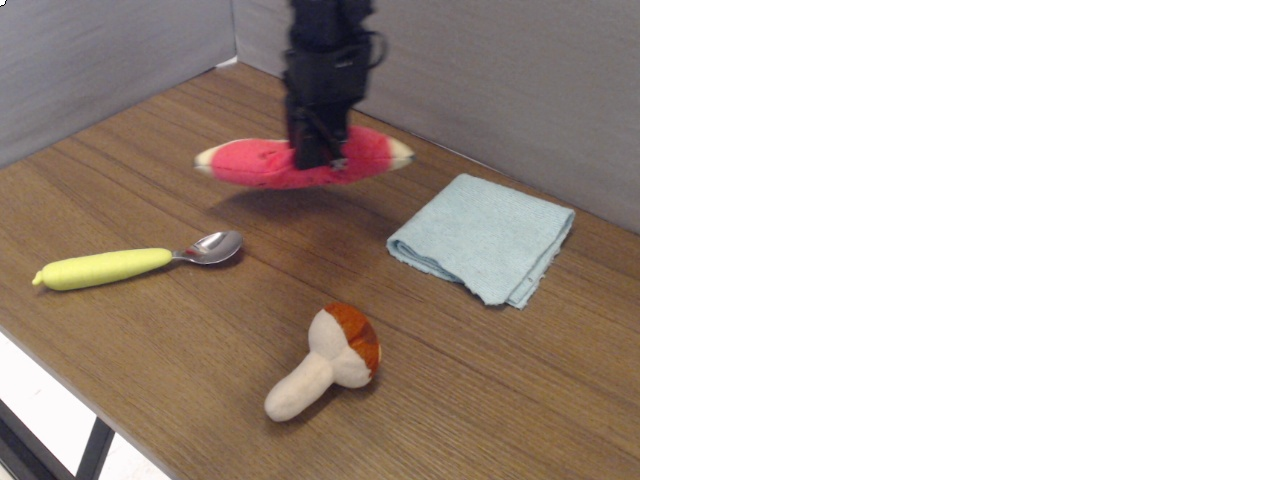

In [12]:
reasoning_img